**Intro**

In this project we have sought to construct models to predict the estimated completion time for a marathon. Features used were age and gender of athletes and the local weather conditions on the day of the event. Athlete data was scraped from various websites and weather data was collected via the Visual Crossing Weather API. The notebooks that collected data are all located in the 'scrape and api' folder.

**Problem Statement**

How do weather conditions impact the time it takes to complete a marathon?

**EDA**

Here we notice that the number of participants may be an issue. Chicago goes from under 10k participants to over 40k. Since we don't know anything about the individuals that are taking part in the marathon, we don't know if this is has an underlying impact on the quality of participants. Below we take a look at a couple different ways to break down the pariticpants to try to negate event size being an issue.

**EDA Takewaways**

Need to do a selection of years not all years will make sense to use. Consider chopping of different percentages from top and bottom or fixed cutoff. Also notice age and gender effects on finish times.

**Models**

The primary metric for evaluating model performace was mean absolute error. Root mean squared error was also looked at during testing.

First models evaluated were linear regression looking that the different methods of splitting up the data as discussed in EDA. This also helped lead to the final determination of only looking at years 2000 - 2018. Spaghetti at the wall method, models were allowed to iterate over all possible feature combinations for each event overnight. This was done to see if there were any features consitently included / excluded from higher performing models.

Additional models were tested for efficacy including Ridge, Lasso, Elastic Net, XGBoostRegressor, GLM gamma. Multiple gridsearches were used as available keeping the highest performing parameters from the previous iteration, dropping the rest and adding new parameters to manage runtime. 

**Conclusion**

No one model reigns supreme but there are some feature that tend to stand out as important. Gender and age group have to be considered when examining a diverse dataset like the ones collected for this project. For weather; temperature, humidity, precipitation, and cloud cover carry the most significant coefficients.

# Imports and Functions

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import pickle

In [3]:
# functions
def num_age(x):
    '''make age categories numeric'''
    if x == '18-39':
        return 0
    elif x == '40-44':
        return 1
    elif x == '45-49':
        return 2
    elif x == '50-54':
        return 3
    elif x == '55-59':
        return 4
    elif x == '60-64':
        return 5
    elif x == '65-69':
        return 6
    return 7


def cat_clean(x):
    '''binary columns were floats, make them ints'''
    return int(x)


def prep(df):
    '''prepare dataframe for EDA'''
    df['age'] = df['age'].apply(lambda x: num_age(x))
    df['clear'] = df['clear'].apply(lambda x: cat_clean(x))
    df['overcast'] = df['overcast'].apply(lambda x: cat_clean(x))
    df['partially_cloudy'] = df['partially_cloudy'].apply(lambda x: cat_clean(x))
    df['rain'] = df['rain'].apply(lambda x: cat_clean(x))

    cols = ['year', 'age', 'male', 'time_seconds', 'minimum_temperature',
           'maximum_temperature', 'temperature', 'relative_humidity', 'wind_speed',
           'precipitation', 'precipitation_cover', 'cloud_cover', 'clear',
           'overcast', 'partially_cloudy', 'rain']

    for col in cols:
        df[col] = pd.to_numeric(df[col], downcast='unsigned')

    df.drop(columns=['maximum_temperature', 'minimum_temperature'], inplace=True)

    event_dict = {year: df[df['year'] == year] for year in df['year'].unique()}
    
    return event_dict


def usable(event_dict, num):
    '''specify which years are usable based on minimum number of participants
    returns dict with years that exceed minimum values are correspoding df'''
    can_use = []
    for year in event_dict.keys():
        if len(event_dict[year]) > num:
            can_use.append(year)
    return {year: event_dict[year] for year in can_use}


def top_n(event_dict, num):
    '''take in event dict and first num of finishers that are desired,
    return df of top n racers for all years, use in conjuction with usable()'''
    df = pd.DataFrame()
    for year in event_dict.keys():
        df = pd.concat([df, event_dict[year].sort_values(by='time_seconds').iloc[:num]], ignore_index=True)
    return df
        
    
def n_range(event_dict, low, high):
    '''take in dictionary of dfs from prep(), upper percentage as float, lower percentage as float
    return df'''
    df = pd.DataFrame()
    for year in event_dict.keys():
        df = pd.concat([df, event_dict[year].sort_values(by='time_seconds').iloc[int(len(event_dict[year]) * low): int(len(event_dict[year]) * high)]], ignore_index=True)
    return df

def model_scores(X_test, y_test, model):
    nl = "\n"
    y_preds = model.predict(X_test)
    return print(f'R2: {model.score(X_test, y_test)}{nl}MAE: {mean_absolute_error(y_test, y_preds)}{nl}MSE: {mean_squared_error(y_test, y_preds)}{nl}RMSE: {mean_squared_error(y_test, y_preds, squared=False)}')

def undo_age(x):
    '''make age categories their division again'''
    if x == 0.0:
        return '18-39'
    elif x == 1.0:
        return '40-44'
    elif x == 2.0:
        return '45-49'
    elif x == 3.0:
        return '50-54'
    elif x == 4.0:
        return '55-59'
    elif x == 5.0:
        return '60-64'
    elif x == 6.0:
        return '65-69'
    return '70+'

# EDA Sample

In [4]:
chicago = pd.read_csv('./data/Chicago_Data/Clean/Clean_Chicago_Results_Weather.csv')

chicago_dict = prep(chicago)

chicago_10 = top_n(usable(chicago_dict, 10_000), 10_000)
    
chicago_20_80 = n_range(usable(chicago_dict, 10_000), .2, .8)

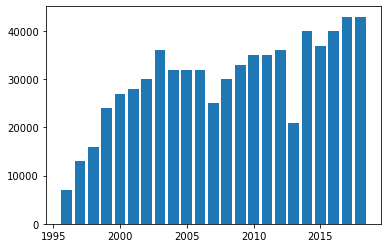

In [5]:
chicago_plotting = chicago.groupby('year').count()

plt.bar(x=chicago_plotting.index, height=chicago_plotting['age']);

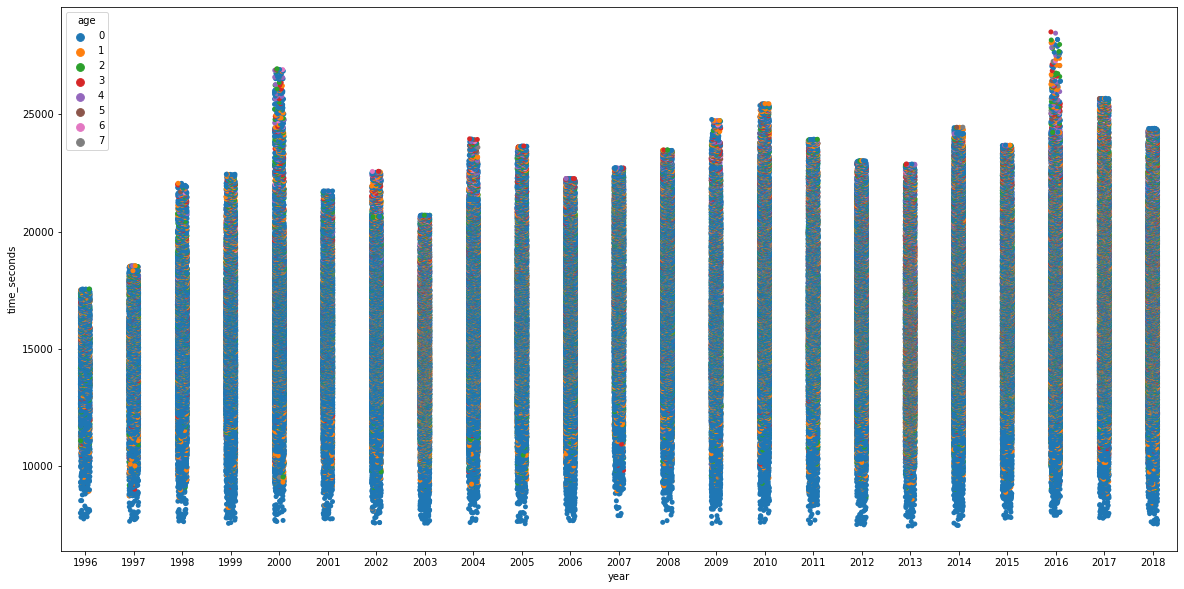

In [111]:
plt.figure(figsize=(20,10))
sns.stripplot(x=chicago['year'], y=chicago['time_seconds'], hue=chicago['age']);

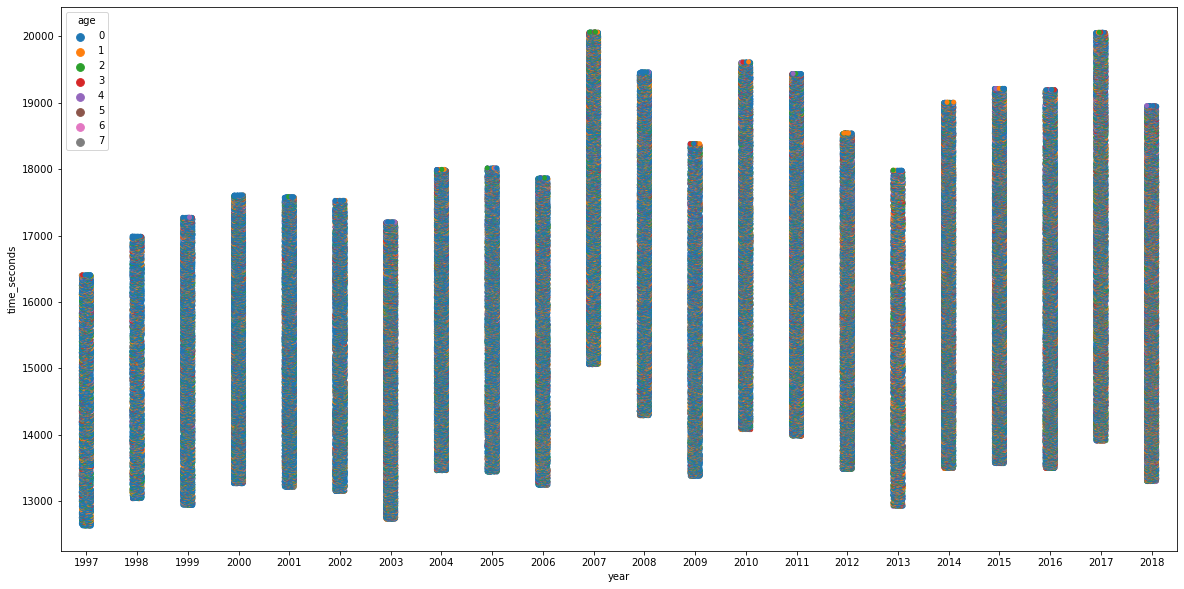

In [113]:
plt.figure(figsize=(20,10))
sns.stripplot(x=chicago_20_80['year'], y=chicago_20_80['time_seconds'], hue=chicago_20_80['age']);

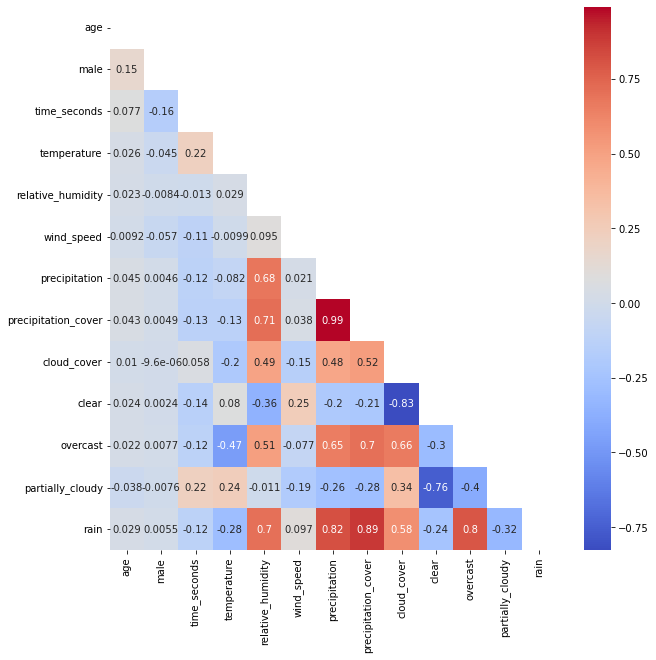

In [114]:
plt.figure(figsize=(10,10))
sns.heatmap(chicago_10.drop(columns='year').corr(), annot=True, cmap='coolwarm', mask=np.triu(np.ones_like(chicago_10.drop(columns='year').corr())));

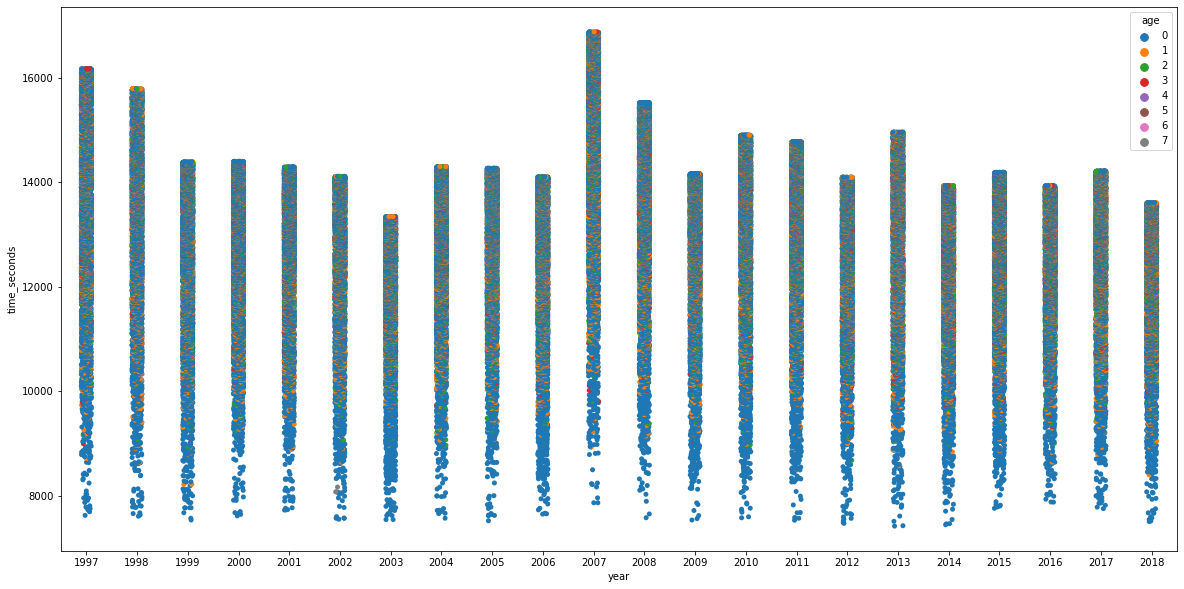

In [115]:
plt.figure(figsize=(20,10))
sns.stripplot(x=chicago_10['year'], y=chicago_10['time_seconds'], hue=chicago_10['age']);

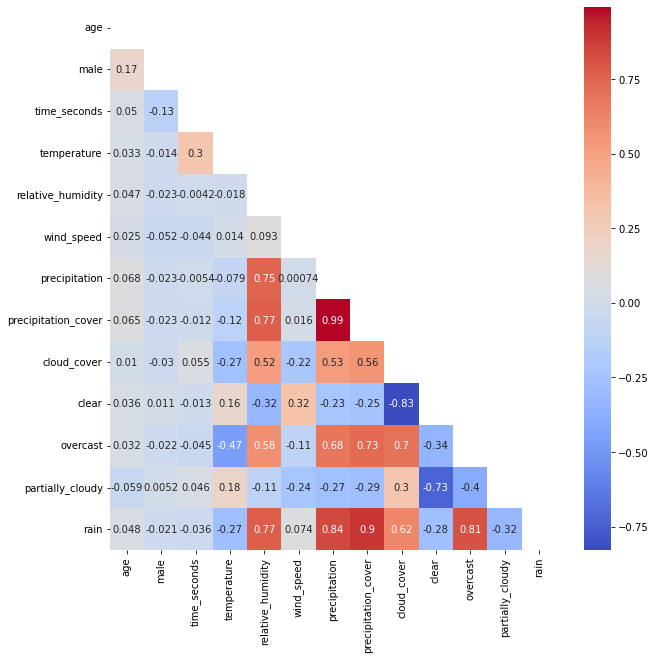

In [116]:
plt.figure(figsize=(10,10))
sns.heatmap(chicago_20_80.drop(columns='year').corr(), annot=True, cmap='coolwarm', mask=np.triu(np.ones_like(chicago_20_80.drop(columns='year').corr())));

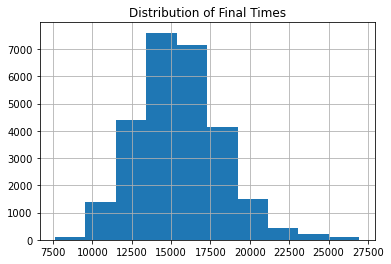

In [11]:
plt.title('Distribution of Final Times')
chicago.query('year == 2000').time_seconds.hist();

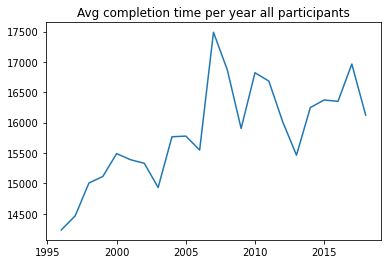

In [14]:
plt.title('Avg completion time per year all participants')
plt.plot(chicago.groupby('year').agg({'time_seconds': 'mean'}));

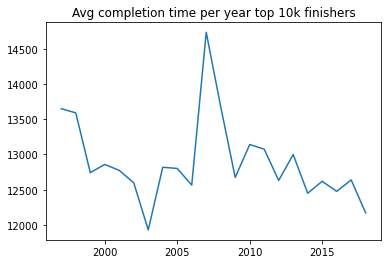

In [15]:
plt.title('Avg completion time per year top 10k finishers')
plt.plot(chicago_10.groupby('year').agg({'time_seconds': 'mean'}));

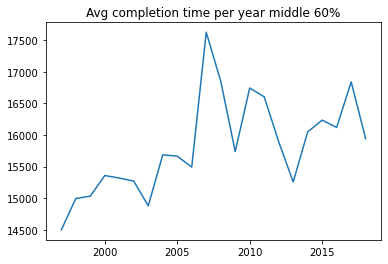

In [16]:
plt.title('Avg completion time per year middle 60%')
plt.plot(chicago_20_80.groupby('year').agg({'time_seconds': 'mean'}));

A brief look into gender and events suggests that they should be kept separate as there is little to no overlap.

In [17]:
london = pd.read_csv('./data/London_Data/Clean/Clean_London_Results_Weather.csv')
nyc = pd.read_csv('./data/NYC_Data/Clean/Clean_NYC_Results_Weather.csv')
boston = pd.read_csv('./data/Boston_Data/Clean/Clean_Boston_Results_Weather.csv')
berlin = pd.read_csv('./data/Berlin_Data/Clean/Clean_Berlin_Results_Weather.csv')
chicago = pd.read_csv('./data/Chicago_Data/Clean/Clean_Chicago_Results_Weather.csv')

london_dict = prep(london)
nyc_dict = prep(nyc)
boston_dict = prep(boston)
berlin_dict = prep(berlin)
chicago_dict = prep(chicago)

london = n_range(usable(london_dict, 0), 0, 1)
nyc = n_range(usable(nyc_dict, 0), 0, 1)
boston = n_range(usable(boston_dict, 0), 0, 1)
berlin = n_range(usable(berlin_dict, 0), 0, 1)
chicago = n_range(usable(chicago_dict, 0), 0, 1)

events = [berlin, boston, chicago, london, nyc]
count = 0
for event in events:
    event['event'] = count
    count += 1
combined_i = pd.concat(events, ignore_index=True)

aggregate = {col: 'mean' for col in combined_i}

combined = combined_i.groupby(['year','event', 'age', 'male']).agg(aggregate)
combined['age'] = combined['age'].apply(lambda x: undo_age(x))

combined = combined[combined['year'] >= 2000]
combined = combined[combined['year'] < 2019]

combined['event'] = np.where(combined['event'] == 0, 'berlin', 
                            np.where(combined['event'] == 1, 'boston',
                                    np.where(combined['event'] == 2, 'chicago',
                                            np.where(combined['event'] == 3, 'london', 'nyc'))))
combined['male'] = np.where(combined['male'] == 0, 'female', 'male')

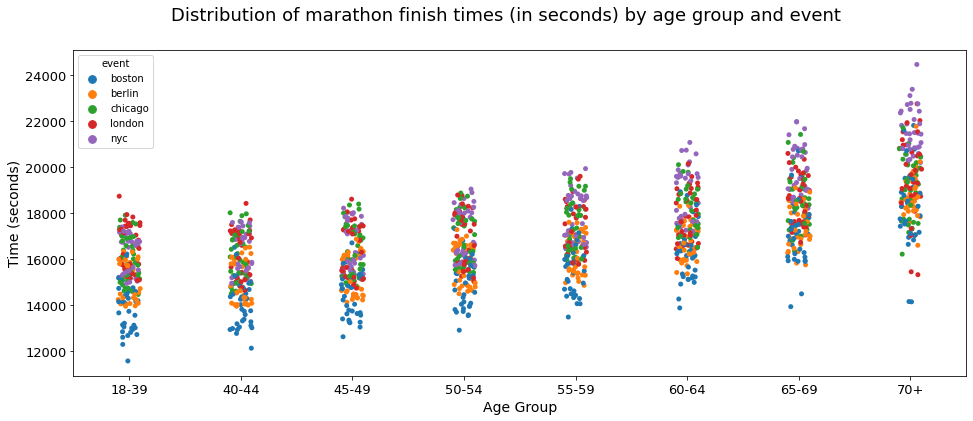

In [18]:
# each dot is a year

plt.figure(figsize=(16,6))
plt.suptitle("Distribution of marathon finish times (in seconds) by age group and event", fontsize=18)
sns.stripplot(x = 'age', 
            y = 'time_seconds', 
            hue='event',
            hue_order=['boston', 'berlin', 'chicago', 'london', 'nyc'],
            data=combined)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Age Group', fontsize=14);
plt.ylabel('Time (seconds)', fontsize=14);

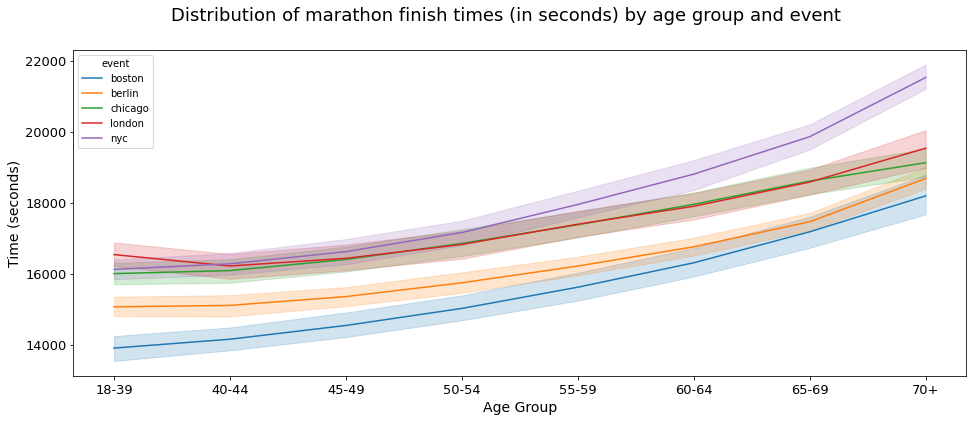

In [19]:
plt.figure(figsize=(16,6))
plt.suptitle("Distribution of marathon finish times (in seconds) by age group and event", fontsize=18)
sns.lineplot(x = 'age', 
            y = 'time_seconds', 
            hue='event',
            hue_order=['boston', 'berlin', 'chicago', 'london', 'nyc'],
            data=combined);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Age Group', fontsize=14);
plt.ylabel('Time (seconds)', fontsize=14);

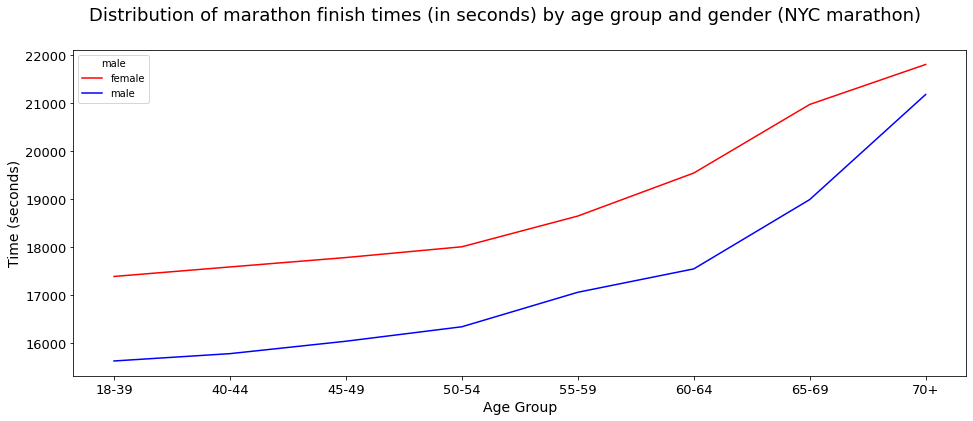

In [20]:
plt.figure(figsize=(16,6))
plt.suptitle("Distribution of marathon finish times (in seconds) by age group and gender (NYC marathon)", fontsize=18)
sns.lineplot(x = 'age', 
            y = 'time_seconds', 
            hue='male',
            hue_order=['female', 'male'],
            palette=['red', 'blue'],
            data=combined.query('year == 2015').query('event == "nyc"'));
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Age Group', fontsize=14);
plt.ylabel('Time (seconds)', fontsize=14);

# Top Models

## Berlin

In [3]:
# read in data
berlin = pd.read_csv('./data/Berlin_Data/Clean/Clean_Berlin_Results_Weather.csv')

# get which years are usable
berlin_dict = prep(berlin)
berlin = n_range(usable(berlin_dict, 9_900), 0, 1)
berlin['event'] = 1

# aggregate on year, age and male
aggregate = {col: 'mean' for col in berlin.drop(columns='year')}
berlin = berlin.groupby(['year', 'age', 'male']).agg(aggregate)

# dummify age categories
berlin['age'] = berlin['age'].apply(lambda x: undo_age(x))
berlin = berlin.merge(pd.get_dummies(berlin['age'], drop_first=True), left_index=True, right_index=True).drop(columns='age')

# train test split
train = berlin[berlin.index.isin(range(2000,2016), level=0)]
test = berlin[berlin.index.isin(range(2016,2019), level=0)]

X_train = train.drop(columns = ['time_seconds', 'clear'])
X_test = test.drop(columns = ['time_seconds', 'clear'])

y_train = train['time_seconds']
y_test = test['time_seconds']


# fit and score model
berlin_model = LinearRegression()
berlin_model.fit(X_train, y_train)
model_scores(X_test, y_test, berlin_model)
pd.DataFrame(list(zip(X_test.columns,np.round(berlin_model.coef_,4))))

R2: 0.927331508024147
MAE: 334.0957839064749
MSE: 172811.79532565898
RMSE: 415.7063811461871


,0,1
0,male,-1480.0387
1,temperature,24.0552
2,relative_humidity,-6.5690
3,wind_speed,7.4267
4,precipitation,-0.0000
5,precipitation_cover,0.0000
6,cloud_cover,-5.1330
7,overcast,525.2323
8,partially_cloudy,41.4661
9,rain,-0.0000


## Boston

In [4]:
# read in data
boston = pd.read_csv('./data/Boston_Data/Clean/Clean_Boston_Results_Weather.csv')

# get which years are usable
boston_dict = prep(boston)
boston = n_range(usable(boston_dict, 9_900), 0, 1)
boston['event'] = 0


# aggregate on year, age and male
aggregate = {col: 'mean' for col in boston.drop(columns=['year'])}
boston = boston.groupby(['year', 'age', 'male']).agg(aggregate)

# dummify age categories
boston['age'] = boston['age'].apply(lambda x: undo_age(x))
boston = boston.merge(pd.get_dummies(boston['age'], drop_first=True), left_index=True, right_index=True).drop(columns='age')

boston = boston.apply(lambda x: round(x,2))

# train test split
train = boston[boston.index.isin(range(2000,2016), level=0)]
test = boston[boston.index.isin([2016, 2018], level=0)]

X_train = train.drop(columns = ['time_seconds', 'clear', 'overcast', 'partially_cloudy'])
X_test = test.drop(columns = ['time_seconds', 'clear', 'overcast', 'partially_cloudy'])

y_train = train['time_seconds']
y_test = test['time_seconds']

# fit and score model
boston_model = LinearRegression()
boston_model.fit(X_train, y_train)
model_scores(X_test, y_test, boston_model)
pd.DataFrame(list(zip(X_test.columns,boston_model.coef_)))

R2: 0.8728437631004872
MAE: 626.6403169292787
MSE: 489029.8505066663
RMSE: 699.3066927369323


,0,1
0,male,-1436.261626
1,temperature,85.893873
2,relative_humidity,10.392624
3,wind_speed,2.467654
4,precipitation,1794.515276
5,precipitation_cover,0.431736
6,cloud_cover,-14.866903
7,rain,125.356825
8,event,0.000000
9,40-44,244.984000


## Chicago

In [5]:
# read in data
chicago = pd.read_csv('./data/Chicago_Data/Clean/Clean_Chicago_Results_Weather.csv')

# get which years are usable
chicago_dict = prep(chicago)
chicago = n_range(usable(chicago_dict, 9_900), 0, 1)

# aggregate on year, age and male
aggregate = {col: 'mean' for col in chicago.drop(columns=['year'])}
chicago = chicago.groupby(['year', 'age', 'male']).agg(aggregate)

# dummify age categories
chicago['event'] = 2
chicago['age'] = chicago['age'].apply(lambda x: undo_age(x))
chicago = chicago.merge(pd.get_dummies(chicago['age'], drop_first=True), left_index=True, right_index=True).drop(columns='age')
chicago.drop(columns=['clear', 'overcast', 'partially_cloudy'], inplace=True)

chicago = chicago.apply(lambda x: round(x,2))

# train test split
train = chicago[chicago.index.isin(range(2000,2016), level=0)]
test = chicago[chicago.index.isin(range(2016,2019), level=0)]

X_train = train.drop(columns = ['time_seconds'])
X_test = test.drop(columns = ['time_seconds'])

y_train = train['time_seconds']
y_test = test['time_seconds']

# fit and score model
chicago_model = XGBRegressor(
     colsample_bytree = 1,
     learning_rate = 0.07,
     max_depth = 3,
     min_child_weight = 5,
     n_estimators = 200,
     nthread = 4,
     objective = 'reg:squarederror',
     subsample = 0.5
)

chicago_model.fit(X_train, y_train)
model_scores(X_test, y_test, chicago_model)
pd.DataFrame(list(zip(chicago_model.feature_names_in_,chicago_model.feature_importances_)))

R2: 0.8907002312361294
MAE: 373.2984855143229
MSE: 287029.54807367804
RMSE: 535.7513864412093


,0,1
0,male,0.097364
1,temperature,0.076711
2,relative_humidity,0.038388
3,wind_speed,0.045860
4,precipitation,0.000000
5,precipitation_cover,0.000000
6,cloud_cover,0.055837
7,rain,0.000000
8,event,0.000000
9,40-44,0.148141


## DF Prep for Remaining Events

In [7]:
# read in data
london = pd.read_csv('./data/London_Data/Clean/Clean_London_Results_Weather.csv')
nyc = pd.read_csv('./data/NYC_Data/Clean/Clean_NYC_Results_Weather.csv')
boston = pd.read_csv('./data/Boston_Data/Clean/Clean_Boston_Results_Weather.csv')
berlin = pd.read_csv('./data/Berlin_Data/Clean/Clean_Berlin_Results_Weather.csv')
chicago = pd.read_csv('./data/Chicago_Data/Clean/Clean_Chicago_Results_Weather.csv')

# get which years are usable
london_dict = prep(london)
nyc_dict = prep(nyc)
boston_dict = prep(boston)
berlin_dict = prep(berlin)
chicago_dict = prep(chicago)

london = n_range(usable(london_dict, 9_900), 0, 1)
nyc = n_range(usable(nyc_dict, 9_900), 0, 1)
boston = n_range(usable(boston_dict, 9_900), 0, 1)
berlin = n_range(usable(berlin_dict, 9_900), 0, 1)
chicago = n_range(usable(chicago_dict, 9_900), 0, 1)

# prep to combine
events = [berlin, boston, chicago, london, nyc]
count = 0
for event in events:
    event['event'] = count
    count += 1

# combine
combined = pd.concat(events, ignore_index=True)

# aggregate events individually
aggregate = {col: 'mean' for col in london.drop(columns='year')}
    
london = london.groupby(['year', 'age', 'male']).agg(aggregate)
nyc = nyc.groupby(['year', 'age', 'male']).agg(aggregate)
boston = boston.groupby(['year', 'age', 'male']).agg(aggregate)
berlin = berlin.groupby(['year', 'age', 'male']).agg(aggregate)
chicago = chicago.groupby(['year', 'age', 'male']).agg(aggregate)

# aggregate combined events
aggregate = {col: 'mean' for col in london}

combined = combined.groupby(['year','event', 'age', 'male']).agg(aggregate)
combined = combined.merge(pd.get_dummies(combined['event'], drop_first=True), left_index=True, right_index=True).drop(columns='event')
combined.columns = ['age', 'male','time_seconds', 'temperature', 'relative_humidity', 'wind_speed', 'precipitation', 'precipitation_cover', 'cloud_cover', 'clear', 'overcast', 
                   'partially_cloudy', 'rain', 'boston', 'chicago', 'london', 'nyc']

# make ages categorical and dummify
berlin['age'] = berlin['age'].apply(lambda x: undo_age(x))
berlin = berlin.merge(pd.get_dummies(berlin['age'], drop_first=True), left_index=True, right_index=True).drop(columns='age')

boston['age'] = boston['age'].apply(lambda x: undo_age(x))
boston = boston.merge(pd.get_dummies(boston['age'], drop_first=True), left_index=True, right_index=True).drop(columns='age')

chicago['age'] = chicago['age'].apply(lambda x: undo_age(x))
chicago = chicago.merge(pd.get_dummies(chicago['age'], drop_first=True), left_index=True, right_index=True).drop(columns='age')

london['age'] = london['age'].apply(lambda x: undo_age(x))
london = london.merge(pd.get_dummies(london['age'], drop_first=True), left_index=True, right_index=True).drop(columns='age')

nyc['age'] = nyc['age'].apply(lambda x: undo_age(x))
nyc = nyc.merge(pd.get_dummies(nyc['age'], drop_first=True), left_index=True, right_index=True).drop(columns='age')

combined['age'] = combined['age'].apply(lambda x: undo_age(x))
combined = combined.merge(pd.get_dummies(combined['age'], drop_first=True), left_index=True, right_index=True).drop(columns='age')
combined.columns = ['male','time_seconds', 'temperature', 'relative_humidity', 'wind_speed', 'precipitation', 'precipitation_cover', 'cloud_cover', 'clear', 'overcast', 
                   'partially_cloudy', 'rain', 'boston', 'chicago', 'london', 'nyc', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70+']

## London

In [8]:
# train test split
train = london[london.index.isin(range(2000,2016), level=0)]
test = london[london.index.isin(range(2016,2019), level=0)]

X_train = train.drop(columns = ['time_seconds', 'clear'])
X_test = test.drop(columns = ['time_seconds', 'clear'])

y_train = train['time_seconds']
y_test = test['time_seconds']

# fit and score model
london_model = ElasticNet(alpha=10, l1_ratio=1.0, max_iter=100_000)
london_model.fit(X_train, y_train)
model_scores(X_test, y_test, london_model)
pd.DataFrame(list(zip(X_test.columns,london_model.coef_)))

R2: 0.9102733768598846
MAE: 399.7680868924779
MSE: 220185.44510783546
RMSE: 469.23921949026754


,0,1
0,male,-1880.404065
1,temperature,26.939149
2,relative_humidity,-12.460085
3,wind_speed,38.303857
4,precipitation,-0.000000
5,precipitation_cover,-0.000000
6,cloud_cover,-6.422871
7,overcast,0.000000
8,partially_cloudy,228.537540
9,rain,-0.000000


## NYC

In [9]:
# train test split
train = nyc[nyc.index.isin(range(2000,2016), level=0)]
test = nyc[nyc.index.isin(range(2016,2019), level=0)]

X_train = train.drop(columns = ['time_seconds', 'clear'])
X_test = test.drop(columns = ['time_seconds', 'clear'])

y_train = train['time_seconds']
y_test = test['time_seconds']

# fit and score model
nyc_model = ElasticNet(alpha=0.1, l1_ratio=0.9797979797979799, max_iter=100_000)
nyc_model.fit(X_train, y_train)
model_scores(X_test, y_test, nyc_model)
pd.DataFrame(list(zip(X_test.columns,nyc_model.coef_)))

R2: 0.9738438910890641
MAE: 256.4421396183765
MSE: 101180.15139095034
RMSE: 318.0882760979259


,0,1
0,male,-1899.008744
1,temperature,34.036573
2,relative_humidity,-3.380317
3,wind_speed,6.176529
4,precipitation,0.000000
5,precipitation_cover,0.000000
6,cloud_cover,12.739158
7,overcast,-783.347042
8,partially_cloudy,-518.093500
9,rain,0.000000


## Combined

In [10]:
# train test split
train = combined[combined.index.isin(range(2000,2016), level=0)]
test = combined[combined.index.isin(range(2016,2019), level=0)]

X_train = train.drop(columns = ['time_seconds', 'clear'])
X_test = test.drop(columns = ['time_seconds', 'clear'])

y_train = train['time_seconds']
y_test = test['time_seconds']

# fit and score model
combined_model = ElasticNet(alpha=1, l1_ratio=1.0, max_iter=10000)
combined_model.fit(X_train, y_train)
model_scores(X_test, y_test, combined_model)
pd.DataFrame(list(zip(X_test.columns,combined_model.coef_)))

R2: 0.8789849816815907
MAE: 490.4068496578689
MSE: 438637.025737602
RMSE: 662.296780709073


,0,1
0,male,-1643.341921
1,temperature,49.352651
2,relative_humidity,-8.210779
3,wind_speed,17.388203
4,precipitation,-0.000000
5,precipitation_cover,-0.624952
6,cloud_cover,3.504430
7,overcast,54.073475
8,partially_cloudy,45.717770
9,rain,99.520141


# Baseline

In [12]:
train = nyc[nyc.index.isin(range(2000,2016), level=0)]
test = nyc[nyc.index.isin(range(2016,2019), level=0)]
y_train = train['time_seconds']
y_test = test['time_seconds']
base_preds = [np.mean(y_train)] * len(y_test)
print(f'nyc base: {mean_absolute_error(y_test, base_preds)}')



train = london[london.index.isin(range(2000,2016), level=0)]
test = london[london.index.isin(range(2016,2019), level=0)]
y_train = train['time_seconds']
y_test = test['time_seconds']
base_preds = [np.mean(y_train)] * len(y_test)
print(f'london base: {mean_absolute_error(y_test, base_preds)}')



train = chicago[chicago.index.isin(range(2000,2016), level=0)]
test = chicago[chicago.index.isin(range(2016,2019), level=0)]
y_train = train['time_seconds']
y_test = test['time_seconds']
base_preds = [np.mean(y_train)] * len(y_test)
print(f'chicago base: {mean_absolute_error(y_test, base_preds)}')



train = boston[boston.index.isin(range(2000,2016), level=0)]
test = boston[boston.index.isin(range(2016,2019), level=0)]
y_train = train['time_seconds']
y_test = test['time_seconds']
base_preds = [np.mean(y_train)] * len(y_test)
print(f'boston base: {mean_absolute_error(y_test, base_preds)}')



train = berlin[berlin.index.isin(range(2000,2016), level=0)]
test = berlin[berlin.index.isin(range(2016,2019), level=0)]
y_train = train['time_seconds']
y_test = test['time_seconds']
base_preds = [np.mean(y_train)] * len(y_test)
print(f'berlin base: {mean_absolute_error(y_test, base_preds)}')



train = combined[combined.index.isin(range(2000,2016), level=0)]
test = combined[combined.index.isin(range(2016,2019), level=0)]
y_train = train['time_seconds']
y_test = test['time_seconds']
base_preds = [np.mean(y_train)] * len(y_test)
print(f'combined base: {mean_absolute_error(y_test, base_preds)}')

nyc base: 1558.910741330211
london base: 1289.3696368958188
chicago base: 1348.9410442583473
boston base: 1455.8137150367647
berlin base: 1286.9889958660247
combined base: 1547.5428056595931
